In this example, we will use Pyreal to find the top contributing features in the Student Performance dataset.

Data source:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.


In [1]:
### Imports
import numpy as np
from pyreal.sample_applications import student_performance
from pyreal.visualize import plot_top_contributors, #swarm_plot

First, we load in the data, and provide human-readable descriptions of every feature. These descriptions will make the resulting explanations much more user friendly.

In [2]:
real_app = student_performance.load_app()
x, y = student_performance.load_data(n_rows=10)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Next, we extract our chosen target variable. In this case, we will be predicting whether a student will pass (score > 10).

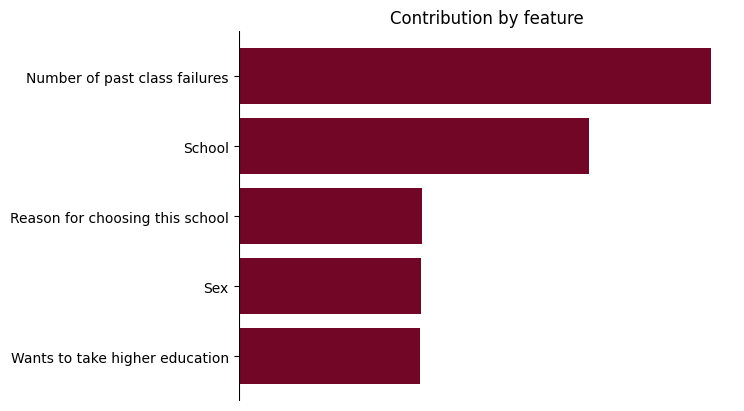

In [3]:
global_explanation = real_app.produce_global_feature_importance()
plot_top_contributors(global_explanation)

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


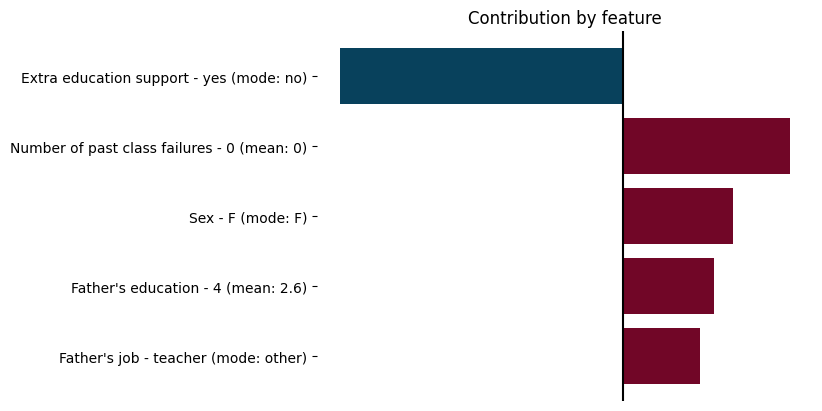

In [10]:
local_explanation = real_app.produce_local_feature_contributions(x)

plot_top_contributors(local_explanation[0])

Now, we will create the transformers. The first will encode boolean features as integers, the second will one hot encode categorical features, and the first with standardize the data.

Some transformation and explanation type combos require post-hoc transformations on the explanations themselves. In this case, we will run SHAP on the one-hot-encoded features, and then recombine the contributions of these features. The OneHotEncoderWrapper includes this functionality.

We can test the accuracy of the model

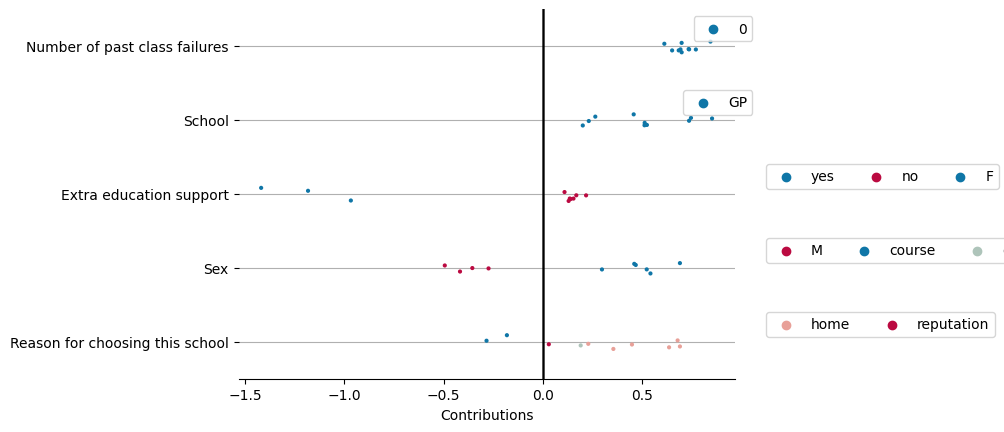

In [35]:
def _parse_multi_contribution(explanation):
    if isinstance(explanation, FeatureContributionExplanation):
        contributions = explanation.get()
        values = explanation.get()
    else:
        contribution_list = [explanation[i]["Contribution"] for i in explanation]
        value_list = [explanation[i]["Feature Value"] for i in explanation]
        feature_list = explanation[0]["Feature Name"].values
        contributions = pd.DataFrame(contribution_list)
        contributions.columns = feature_list
        values = pd.DataFrame(value_list)
        values.columns = feature_list
    return contributions, values


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyreal.realapp import realapp
from pyreal.types.explanations.feature_based import (
    FeatureContributionExplanation,
    FeatureImportanceExplanation,
)
from pyreal.visualize.visualize_config import (
    NEGATIVE_COLOR,
    NEGATIVE_COLOR_LIGHT,
    NEUTRAL_COLOR,
    PALETTE_CMAP,
    POSITIVE_COLOR,
    POSITIVE_COLOR_LIGHT,
)

def swarm_plot(explanation, type="swarm", n=5, show=False, filename=None, legend=True, **kwargs):
    """
    Generates a strip plot (type="strip") or a swarm plot (type="swarm") from a set of feature
    contributions.

    Args:
        explanation (DataFrame or FeatureBased):
            One output DataFrame from RealApp.produce_local_feature_contributions OR
            FeatureContributions explanation object
        type (String, one of ["strip", "swarm"]:
            The type of plot to generate
        n (int):
            Number of features to show
        show (Boolean):
            Whether or not to show the figure
        filename (string or None):
            If not None, save the figure as filename
        legend (Boolean):
            If True, show a colorbar legend
        **kwargs:
            Additional arguments to pass to seaborn.swarmplot or seaborn.stripplot
    """
    contributions, values = _parse_multi_contribution(explanation)

    average_importance = np.mean(abs(contributions), axis=0)
    order = np.argsort(average_importance)[::-1]
    num_cats = [0]
    for i in range(n):
        hues = values.iloc[:, order[i : i + 1]]
        hues = hues.melt()["value"]
        num_colors = len(np.unique(hues.astype("str")))
        palette = sns.blend_palette(
            [NEGATIVE_COLOR_LIGHT, NEUTRAL_COLOR, POSITIVE_COLOR_LIGHT], n_colors=num_colors
        )
        if type == "strip":
            ax = sns.stripplot(
                x="value",
                y="variable",
                hue=hues,
                data=contributions.iloc[:, order[i : i + 1]].melt(),
                palette=palette,
                legend=True,
                size=3,
                **kwargs
            )
        elif type == "swarm":
            ax = sns.swarmplot(
                x="value",
                y="variable",
                hue=hues,
                data=contributions.iloc[:, order[i : i + 1]].melt(),
                palette=palette,
                legend=True,
                size=3,
                **kwargs
            )
        else:
            raise ValueError("Invalid type %s. Type must be one of [strip, swarm]." % type)

        h,l = ax.get_legend_handles_labels()
        num_cats.append(len(h) - num_cats[-1])
        plt.axvline(x=0, color="black", linewidth=1)
        ax.grid(axis="y")
        ax.set_ylabel("")
        ax.set_xlabel("Contributions")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    num_cats = num_cats[1:]
    h,l = ax.get_legend_handles_labels()
    r = 0
    l1 = ax.legend(h[0:num_cats[0]],l[0:num_cats[0]], bbox_to_anchor=(1.05, 1), ncol=num_cats[0])
    r += num_cats[0]
    for i in range(1, len(num_cats)):
        if i > 1:
            ax.add_artist(l2)
        else:
            ax.add_artist(l1)
        l2 = ax.legend(h[r:r+num_cats[i]],l[r:r+num_cats[i]], bbox_to_anchor=(1.05, 1-(i*.2)), ncol=num_cats[i])
        r += num_cats[i]



    '''if legend:
        ax = plt.gca()
        norm = plt.Normalize(0, 1)
        sm = plt.cm.ScalarMappable(cmap=PALETTE_CMAP, norm=norm)
        sm.set_array([])
        cbar = ax.figure.colorbar(sm)
        cbar.ax.get_yaxis().set_ticks([])
        cbar.ax.text(1.5, 0.05, "low", ha="left", va="center")
        cbar.ax.text(1.5, 0.95, "high", ha="left", va="center")
        cbar.ax.set_ylabel("Feature Value", rotation=270)
        cbar.ax.get_yaxis().labelpad = 15'''

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    if show:
        plt.show()

swarm_plot(local_explanation, type="strip")

In [30]:
preds = lfc.model_predict(X)
print("Accuracy: %.2f%%" % (np.mean(preds==y)*100))

NameError: name 'lfc' is not defined

Finally, we fit our explainer, and take a look at the most predictive features.

In [ ]:
lfc.fit()

In [ ]:
from pyreal import visualize

input_to_explain = X.iloc[0]
explanation = lfc.produce(input_to_explain)

visualize.plot_top_contributors(explanation, select_by="absolute", show=True)

We can also generate a global feature importance explanation, that summarizes the overall importance of features across all inputs.

In [ ]:
from pyreal.explainers import GlobalFeatureImportance

gfi = GlobalFeatureImportance(model="model.pkl",
                              x_train_orig=X, transformers=transformers,
                              feature_descriptions=feature_descriptions,
                              fit_on_init=True)

importances = gfi.produce(input_to_explain)
visualize.plot_top_contributors(importances, select_by="absolute",
                                show=True)
